In [7]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import nibabel as nib
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_roi
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
from neuromaps import images
from nilearn import plotting
import seaborn as sns
from scipy.spatial.distance import cdist
from brainspace.null_models.variogram import SurrogateMaps
from brainspace.gradient.kernels import compute_affinity
from matplotlib.colors import ListedColormap

In [8]:
main_path = "/home/m-ehara/project/diffparc-smk"

In [9]:
data_path = main_path + "/PNI/"
results_path = main_path + "/results/funcparc/group/clustering/"
#fig_path = main_path + "/results/diffparc/figures/"

In [10]:
import numpy as np

f = results_path + "/tpl-MNI152NLin6Asym_label-fullBF_desc-correlationMatrix_1p6mm.npz"
data = np.load(f)

print(data.files)

['corr_group', 'n_bf_voxels', 'n_parcels', 'n_features']


In [11]:
correlation = data["corr_group"]   # (subjects, 599, 400)
print(correlation.shape)

(10, 599, 400)


In [12]:
import numpy as np
import nibabel as nib

seed_file = "/home/m-ehara/project/diffparc-smk/resources/seed_1p6mm.nii.gz"  # ここはあなたの実ファイルに合わせる
seed = nib.load(seed_file).get_fdata()

indices = np.argwhere(seed > 0)   # (599, 3)
print(indices.shape)


(599, 3)


In [18]:
import os
import numpy as np

orig = np.load(results_path + "/tpl-MNI152NLin6Asym_label-fullBF_desc-correlationMatrix_1p6mm.npz")

out = results_path + "/tpl-MNI152NLin6Asym_label-fullBF_desc-correlationMatrix_1p6mm_withIndices.npz"

np.savez(
    out,
    corr_group=orig["corr_group"],
    n_bf_voxels=orig["n_bf_voxels"],
    n_parcels=orig["n_parcels"],
    n_features=orig["n_features"],
    indices=indices
)

print("saved:", out)


saved: /home/m-ehara/project/diffparc-smk/results/funcparc/group/clustering//tpl-MNI152NLin6Asym_label-fullBF_desc-correlationMatrix_1p6mm_withIndices.npz


In [19]:
data = np.load(results_path + "/tpl-MNI152NLin6Asym_label-fullBF_desc-correlationMatrix_1p6mm_withIndices.npz")
correlation = data["corr_group"]
indices = data["indices"]

print(correlation.shape, indices.shape)

(10, 599, 400) (599, 3)


In [20]:
data = load(results_path + '/tpl-MNI152NLin6Asym_label-fullBF_desc-correlationMatrix_1p6mm.npz') #change the npz file name as necessary
correlation = data['corr_group']
indices = data['indices']

KeyError: 'indices is not a file in the archive'

In [28]:
corr_avg = np.nanmean(correlation,axis=0)
corr_avg.min()

-0.22324023

In [22]:
abs_corr_avg = abs(corr_avg)
abs_corr_avg.shape

(599, 400)

In [23]:
abs_corr_avgFC = abs_corr_avg[:,:-19]
abs_corr_avgFC.shape

(599, 381)

In [24]:
pd.DataFrame(abs_corr_avgFC).to_csv(results_path + f'Func_abs-corr-avgFC.csv', index=False)

NameError: name 'fig_path' is not defined

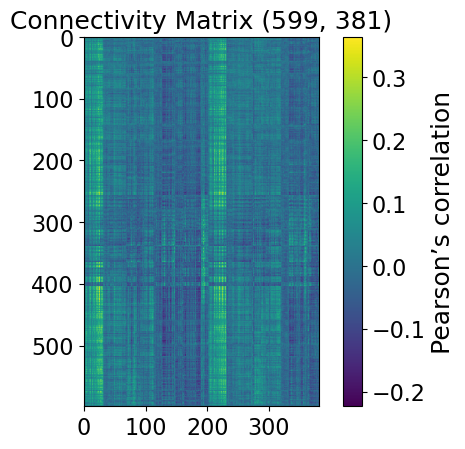

In [25]:
f, ax = plt.subplots(1,1,dpi=100)
im = ax.imshow(corr_avg[:,:-19])
ax.set_title('Connectivity Matrix {}'.format(corr_avg[:,:-19].shape), fontsize=18)
cbar = plt.colorbar(im)
cbar.set_label("Pearson’s correlation", fontsize=18)
font_size = 16 # Adjust as appropriate.
cbar.ax.tick_params(labelsize=font_size)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Parcellated_func-ConnMatrix.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [16]:
# Average correlation matrix
corr_avg = np.nanmean(correlation,axis=0)
corr_avg += 1
corr_avg[np.isnan(corr_avg)] = 1

In [17]:
# remove the extra subcortical regions 
corr_avgFC = corr_avg[:,:-19]

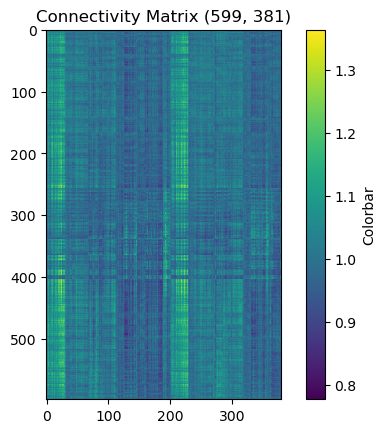

In [18]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
im = ax.imshow(corr_avgFC)
ax.set_title('Connectivity Matrix {}'.format(corr_avgFC.shape))
cbar = plt.colorbar(im)
cbar.set_label("Colorbar")
plt.show()

NameError: name 'fig_path' is not defined

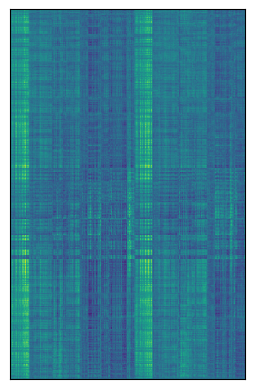

In [19]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
im = ax.imshow(corr_avgFC)
#ax.set_title('Connectivity Matrix {}'.format(corr_avgFC.shape))
#cbar = plt.colorbar(im)
#cbar.set_label("Streamline counts (log-scaled)")
plt.xticks([])
plt.yticks([])
plt.savefig(fig_path + f'Func_ConnMatrix_forSuppFig.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [54]:
pd.DataFrame(corr_avgFC).to_csv(results_path + f'Func_corr-avgFC.csv', index=False)

In [55]:
sm = compute_affinity(corr_avgFC,kernel='normalized_angle')

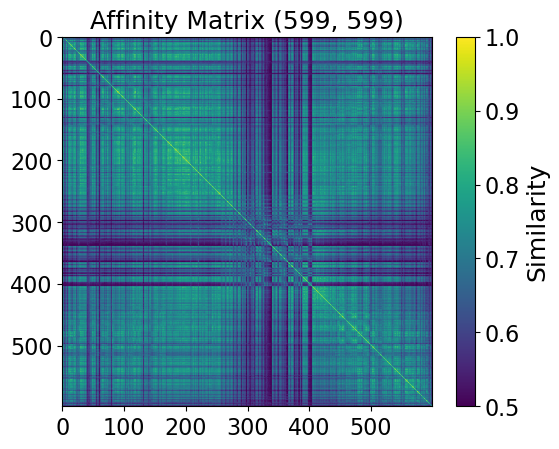

In [56]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
im = ax.imshow(sm)
ax.set_title('Affinity Matrix {}'.format(sm.shape), fontsize=18)
cbar = plt.colorbar(im)
cbar.set_label("Similarity", fontsize=18)
font_size = 16 # Adjust as appropriate.
cbar.ax.tick_params(labelsize=font_size)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Parcellated_func-SimMatrix.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

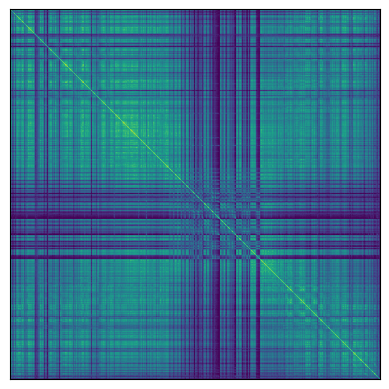

In [57]:

# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
im = ax.imshow(sm)
#ax.set_title('Affinity Matrix {}'.format(sm.shape), fontsize=18)
#cbar = plt.colorbar(im)
#cbar.set_label("Similarity", fontsize=18)
#font_size = 16 # Adjust as appropriate.
#cbar.ax.tick_params(labelsize=font_size)
plt.xticks([])
plt.yticks([])
plt.savefig(fig_path + f'Func_SimMatrix_suppFig.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [13]:
fname = (main_path + '/resources/seed_1p6mm.nii.gz')

In [26]:
n_components=100 # specify gradinet components here

In [29]:
from brainspace.gradient import GradientMaps

# Build gradients using diffusion maps and normalized angle and fit to the data.
gm = GradientMaps(n_components=n_components, 
                  kernel='normalized_angle',
                  approach='dm',
                  random_state=0)
print(gm.fit(corr_avg))

GradientMaps(n_components=100, random_state=0)


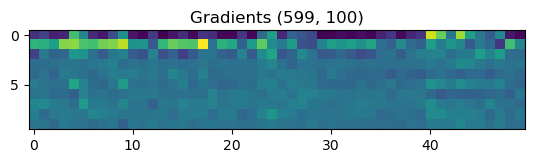

In [30]:
# Plot this gradients (up to 10 component and 50 BF voxel)
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(gm.gradients_[:50, :10].T)
ax.set_title('Gradients {}'.format(gm.gradients_.shape))
plt.show()

In [31]:
# save the gradient
pd.DataFrame(gm.gradients_).to_csv(results_path + f'Func_gradients-{n_components}_seed-BASF_1p6mm.csv', index=False)

In [15]:

fname = (results_path + 'Func_gradient_{0}.nii.gz')

In [32]:
# save the (up to 4 components) as nifti files
# get seed data
seed_file = (main_path + '/resources/seed_1p6mm.nii.gz')
seed = nib.load(seed_file)
seed_vol = seed.get_fdata()

for gradi in range(n_components):

    grad_vol = np.zeros(seed_vol.shape)
    grad_vol[indices[:,0],indices[:,1],indices[:,2]] = gm.gradients_[:,gradi] 

    grad_nib = nib.Nifti1Image(grad_vol,affine=seed.affine,header=seed.header)
    grad_nib.to_filename(results_path + f'Func_gradient_{gradi+1}.nii.gz')

In [33]:
G_idx = {}
G_values = {}
for g in range(1,5):
    G_nii = nib.load(fname.format(g)).get_fdata()
    G_idx[g] = np.argwhere(G_nii)
    G_values[g] = G_nii[G_idx[g][:,0], G_idx[g][:,1], G_idx[g][:,2]].flatten()

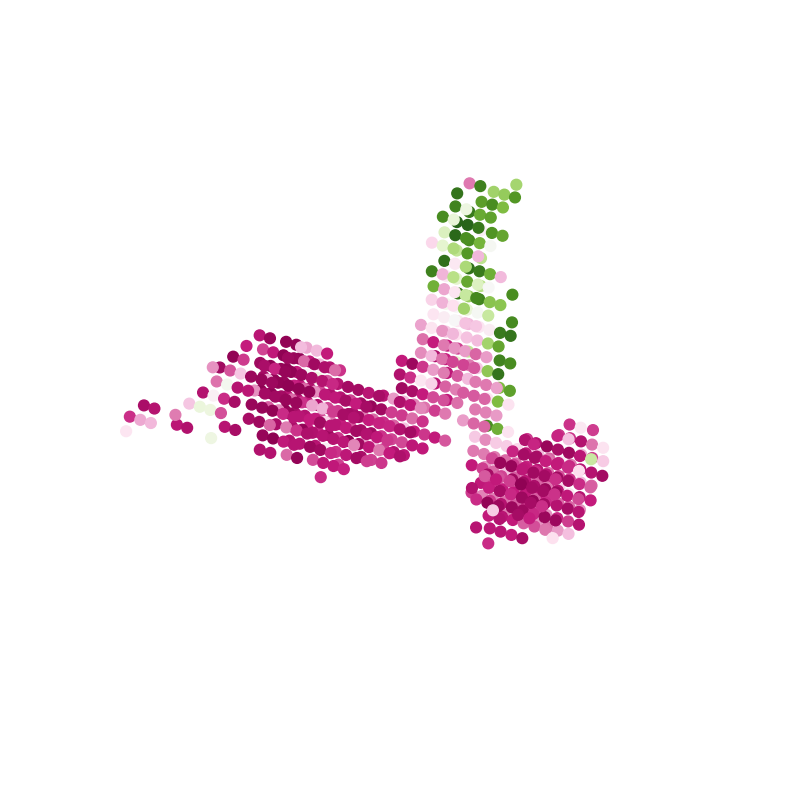

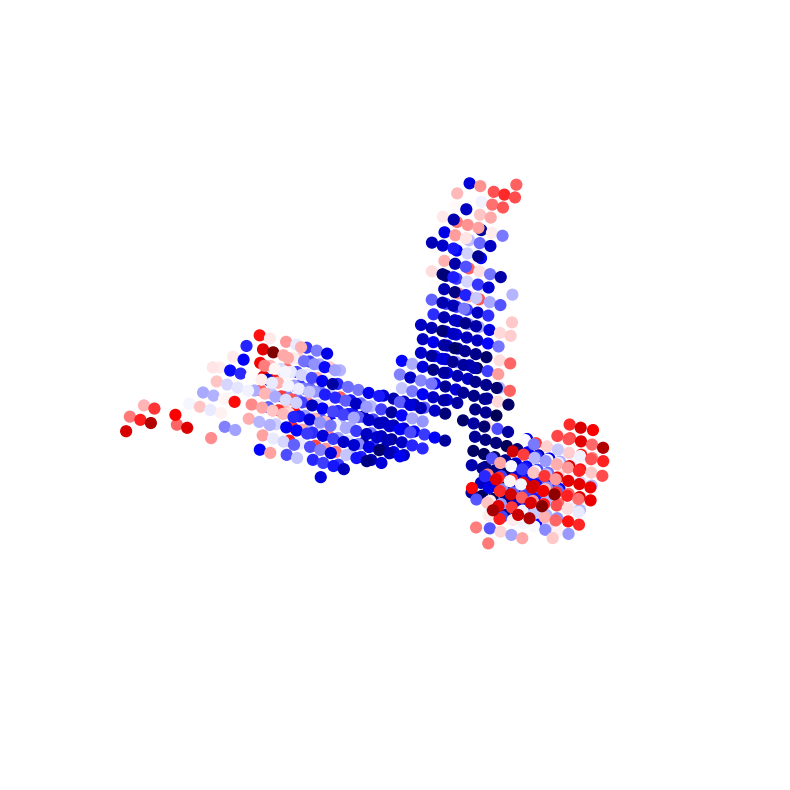

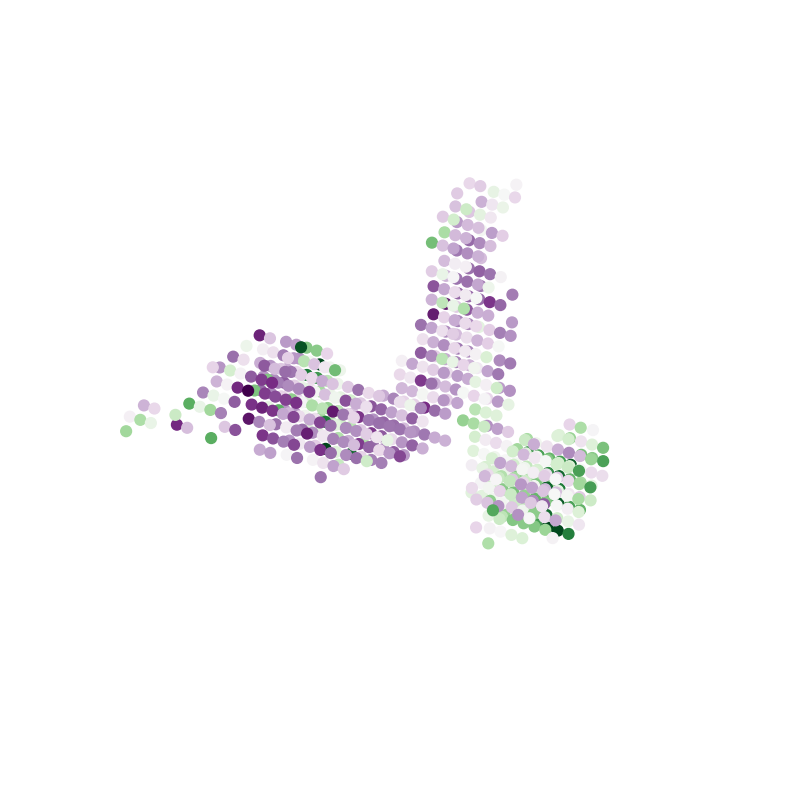

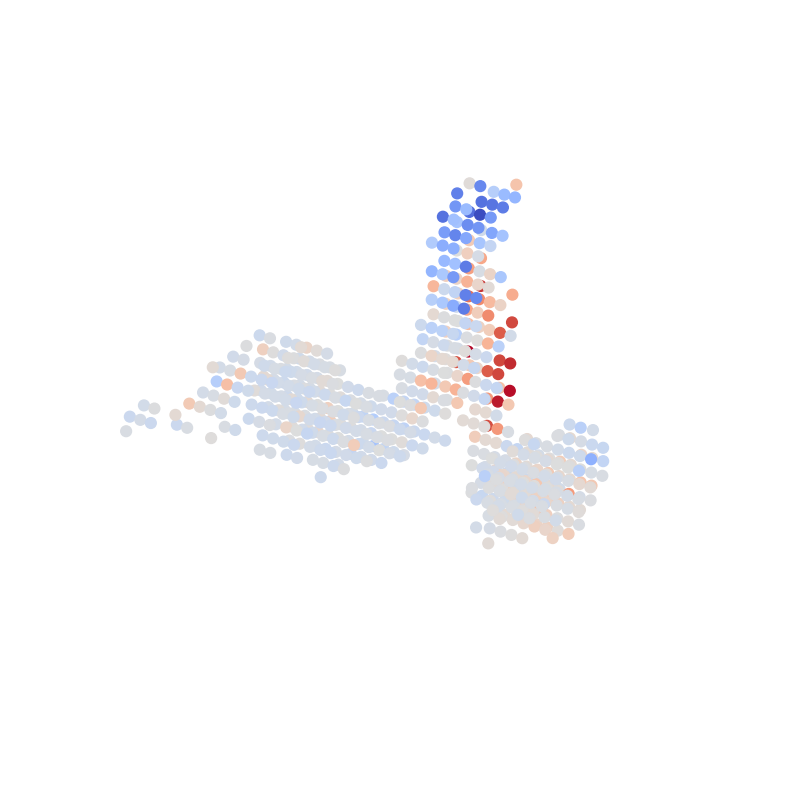

In [38]:
colors = ['seismic','PiYG','seismic','PRGn','coolwarm',]

for g in range(1,5):
    # Plot using 3D scatter plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.dist=10
    ax.set_axis_off()
    
    ax.scatter(
        G_idx[g][:,0],
        G_idx[g][:,1],
        G_idx[g][:,2],
        s=60, alpha=1,
        cmap=colors[g], vmin=G_values[g].min(), vmax=G_values[g].max(), 
        c=G_values[g]
    )
    # Add legend    
    #norm = matplotlib.colors.Normalize(G_values[g].min(), G_values[g].max())
    #cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
    #cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=colors[g]), 
    #                 ticks=[G_values[g].min(), G_values[g].max()], cax=cb_ax, orientation='horizontal')
    #cb.set_label(f"Gradient {g}", fontsize=18, labelpad=-10, weight=600)
    #cb.ax.set_xticklabels(['−','+'], fontsize=20, weight=600) 
    
    #plt.savefig(fig_path + f'Func_Gradient_{g}_scatterplot.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()